In [1]:
import os
import glob
import bz2
import pandas as pd
import numpy as np
from tqdm.notebook import tqdm
import matplotlib.pyplot as plt
from collections import defaultdict

In [2]:
# Specifying filename and directory
data_dir = os.getcwd() + '/data'
quotebank_dir = data_dir + "/Quotebank"
quotebank_bz2 = os.listdir(quotebank_dir)
print(quotebank_bz2)

# Change directory
os.chdir(quotebank_dir)

['.DS_Store', 'quotes-2020-movies.json.bz2', 'quotes-2015-movies.json.bz2', 'quotes-2017-movies.json.bz2', 'quotes-2018-movies.json.bz2', 'quotes-2016-movies.json.bz2', 'quotes-2019-movies.json.bz2']


In [3]:
df = pd.DataFrame()
for year_file in tqdm(quotebank_bz2):
    if year_file != '.DS_Store':
        temp =  pd.read_json(year_file, lines=True, compression='bz2')
        df = pd.concat([df, temp], ignore_index = True) 
df.shape

  0%|          | 0/7 [00:00<?, ?it/s]

(58413, 10)

In [4]:
df.head()

,quoteID,quotation,speaker,qids,date,numOccurrences,probas,urls,phase,movie
0,2019-02-03-035259,"Onwards and upwards, we've got to look at it p...",David Drew,"[Q15457830, Q5233072, Q56427827, Q728653]",2019-02-03 07:32:34,7,"[[David Drew, 0.9465], [None, 0.0495], [Erin B...",[http://www.brisbanetimes.com.au/sport/cricket...,E,Onward
1,2019-05-24-017082,"Dimple Kapadia and Clemence Poesy, the French ...",Dimple Kapadia,[Q158558],2019-05-24 19:19:22,1,"[[Dimple Kapadia, 0.749], [None, 0.1498], [Chr...",[https://www.bollywoodmantra.com/news/dimple-k...,E,Tenet
2,2019-12-09-045724,It's more of an origin story for the Birds of ...,Margot Robbie,[Q1924847],2019-12-09 17:00:00,9,"[[Margot Robbie, 0.8018], [None, 0.1872], [Ewa...",[https://comicbook.com/dc/2019/12/09/how-birds...,E,Birds of Prey: And the Fantabulous Emancipatio...
3,2019-09-18-023933,Harley Quinn... and the Birds of Prey.,None,[],2019-09-18 12:52:00,4,"[[None, 0.5105], [Christina Hodson, 0.3948], [...",[https://www.comicbookmovie.com/birds_of_prey/...,E,Birds of Prey: And the Fantabulous Emancipatio...
4,2019-08-26-013468,Dr. West brings significant healthcare experie...,None,[],2019-08-26 21:00:22,1,"[[None, 0.8808], [Edward A. Kangas, 0.1192]]",[https://healthcare.dmagazine.com/2019/08/26/t...,E,Tenet


Removing NaN-values. We see that these only occur in the `movie` attribute which right now is due to an issue in the data filtering. 

In [5]:
df.isnull().any()

quoteID           False
quotation         False
speaker           False
qids              False
date              False
numOccurrences    False
probas            False
urls              False
phase             False
movie             False
dtype: bool

In [6]:
df = df.loc[-df.isnull().any(axis=1)]

In [7]:
df.shape

(58413, 10)

### Dealing with the speakers

We investigate how many quotes does not have an obvious speaker and is denoted by 'None'. Turns out that it is approximately 38%.

In [8]:
number_none_speakers = len(df[df.speaker == 'None'])

print(f"'None'-speakers: {number_none_speakers}")
print(f"Total fraction of 'None'-speakers: {number_none_speakers / len(df)}")

'None'-speakers: 22538
Total fraction of 'None'-speakers: 0.38583876876722645


Even though the single speakers are not really important for answering our research questions, we choose to clean the data by chaning 'None'-speakers to the speaker with second highest probability from the `df.probas` attribute. 
<span style="color:red"> *TODO*: THIS MIGHT NEED RE-ENGENEERING TO A MORE EXCLUSIVE THING. right now trump gets assigned to a lot. </span>

In [9]:
# Removes speaker as being None to being the second most likely in case speaker is 'None'
proba_threshhold = 0.15

secondary_speaker = [df['probas'][i][1][0] if (speaker == 'None') and (float(df['probas'][i][1][1]) > proba_threshhold) else speaker for i, speaker in enumerate(tqdm(df['speaker']))]
df['speaker'] = secondary_speaker

  0%|          | 0/58413 [00:00<?, ?it/s]

In [10]:
number_none_speakers = len(df[df.speaker == 'None'])

print(f"'None'-speakers: {number_none_speakers}")
print(f"Total fraction of 'None'-speakers: {number_none_speakers / len(df)}")

'None'-speakers: 8911
Total fraction of 'None'-speakers: 0.15255165802133086


In [11]:
df.head()

,quoteID,quotation,speaker,qids,date,numOccurrences,probas,urls,phase,movie
0,2019-02-03-035259,"Onwards and upwards, we've got to look at it p...",David Drew,"[Q15457830, Q5233072, Q56427827, Q728653]",2019-02-03 07:32:34,7,"[[David Drew, 0.9465], [None, 0.0495], [Erin B...",[http://www.brisbanetimes.com.au/sport/cricket...,E,Onward
1,2019-05-24-017082,"Dimple Kapadia and Clemence Poesy, the French ...",Dimple Kapadia,[Q158558],2019-05-24 19:19:22,1,"[[Dimple Kapadia, 0.749], [None, 0.1498], [Chr...",[https://www.bollywoodmantra.com/news/dimple-k...,E,Tenet
2,2019-12-09-045724,It's more of an origin story for the Birds of ...,Margot Robbie,[Q1924847],2019-12-09 17:00:00,9,"[[Margot Robbie, 0.8018], [None, 0.1872], [Ewa...",[https://comicbook.com/dc/2019/12/09/how-birds...,E,Birds of Prey: And the Fantabulous Emancipatio...
3,2019-09-18-023933,Harley Quinn... and the Birds of Prey.,Christina Hodson,[],2019-09-18 12:52:00,4,"[[None, 0.5105], [Christina Hodson, 0.3948], [...",[https://www.comicbookmovie.com/birds_of_prey/...,E,Birds of Prey: And the Fantabulous Emancipatio...
4,2019-08-26-013468,Dr. West brings significant healthcare experie...,None,[],2019-08-26 21:00:22,1,"[[None, 0.8808], [Edward A. Kangas, 0.1192]]",[https://healthcare.dmagazine.com/2019/08/26/t...,E,Tenet


Furthermore, we realize that there is a super specific timestamp on the `date` attribute. Later on we will match daily box office sales with the Quotebank data, so we strip the timestamps from the specific time of the date and focus solely on the date.

In [12]:
# Remove last part of date from the quoteID date string to be able to have an average daily sentiment score
reduced_dates = [("-").join(date.split("-")[:3]) for date in tqdm(df.quoteID)]
df['date'] = reduced_dates

  0%|          | 0/58413 [00:00<?, ?it/s]

In [13]:
df.head()

,quoteID,quotation,speaker,qids,date,numOccurrences,probas,urls,phase,movie
0,2019-02-03-035259,"Onwards and upwards, we've got to look at it p...",David Drew,"[Q15457830, Q5233072, Q56427827, Q728653]",2019-02-03,7,"[[David Drew, 0.9465], [None, 0.0495], [Erin B...",[http://www.brisbanetimes.com.au/sport/cricket...,E,Onward
1,2019-05-24-017082,"Dimple Kapadia and Clemence Poesy, the French ...",Dimple Kapadia,[Q158558],2019-05-24,1,"[[Dimple Kapadia, 0.749], [None, 0.1498], [Chr...",[https://www.bollywoodmantra.com/news/dimple-k...,E,Tenet
2,2019-12-09-045724,It's more of an origin story for the Birds of ...,Margot Robbie,[Q1924847],2019-12-09,9,"[[Margot Robbie, 0.8018], [None, 0.1872], [Ewa...",[https://comicbook.com/dc/2019/12/09/how-birds...,E,Birds of Prey: And the Fantabulous Emancipatio...
3,2019-09-18-023933,Harley Quinn... and the Birds of Prey.,Christina Hodson,[],2019-09-18,4,"[[None, 0.5105], [Christina Hodson, 0.3948], [...",[https://www.comicbookmovie.com/birds_of_prey/...,E,Birds of Prey: And the Fantabulous Emancipatio...
4,2019-08-26-013468,Dr. West brings significant healthcare experie...,None,[],2019-08-26,1,"[[None, 0.8808], [Edward A. Kangas, 0.1192]]",[https://healthcare.dmagazine.com/2019/08/26/t...,E,Tenet


The attribute `phase` seem to mostly take the values 'E'. The investigation below shows that all of the entries are in fact 'E' so we decide to remove it from the dataframe. From the documentation of the data we also do not find it relevant for our case. Also we won't be using the `quoteID` attribute but instead the WikiData compatible `qids`.

In [14]:
np.unique(df.phase, return_counts=True)
df = df.drop(['phase', 'quoteID'], axis=1)

### Handling outliers in the numOccurrences

We want to check for outliers in the number of occurrences as it is the only numercal attribute left. By a first descriptive analysis of the variable we suspect something fishy as the maximum number is quite high. We note that there are no weird values on the other side as the minimum value of occurrences is 1.

In [15]:
df.numOccurrences.describe()

count    58413.000000
mean        11.091024
std        522.778938
min          1.000000
25%          1.000000
50%          1.000000
75%          2.000000
max      58945.000000
Name: numOccurrences, dtype: float64

We also want to see if this seems unfeasible when looking at the plots. The boxplot reveals that there is a need to investigate outliers and the plot of the occurences reveal that the distribution seem to follow a strong power law. We will have to deal with outliers to get anything meaningful from the data.

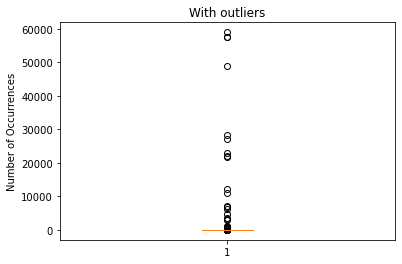

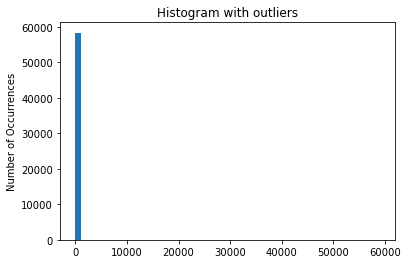

In [16]:
plt.boxplot(df.numOccurrences)
plt.ylabel("Number of Occurrences")
plt.title("With outliers")
plt.show()

plt.hist(df.numOccurrences, bins=50)
plt.ylabel("Number of Occurrences")
plt.title("Histogram with outliers")
plt.show()

As a start we will investigate whether the IQR outlier removal approach is feasible for our data. The code is taken and re-written from our homework 1 hand-in.


In [17]:
def get_outliers(data):
    """ Filters out outliers that is more than 1.5 times lower than the 25% quantile and above 1.5 times higher than the 
    75% quantile.
    
    Input is the sub-dataframe consisting of the columns assosiacted with kilometrage data.
    returns the indeces for rows that contains outliers.
    
    Function idea is taken from our implementation in Homework 1
    
    """
    
    series = pd.Series(data)
    
    IQR = (series.quantile(0.75) - series.quantile(0.25)) 
    outlier_threshold = IQR * 1.5

    # calculating decision boundaries
    lower = series.quantile(0.25)-outlier_threshold
    upper = series.quantile(0.75)+outlier_threshold

    # Finds the union of outlier indeces from the previous column and the current column
    outlier_indeces = np.union1d(series.index[series < lower], series.index[series > upper])

    return np.array([int(x) for x in outlier_indeces])

In [18]:
outlier_ids = get_outliers(df.numOccurrences)
print(f"Number of IQR outliers: {len(outlier_ids)}")
print(f"Ratio of IQR outliers in original data: {len(outlier_ids)/len(df)}")

Number of IQR outliers: 9564
Ratio of IQR outliers in original data: 0.16373067639052952


In [19]:
df = df.drop(outlier_ids)
df.index = np.arange(len(df))
df.shape

(48849, 8)

So 15% of the data was determined to be outliers based on the IQR range. We visualize the new distribution in the following. 

In [20]:
df.describe()

,numOccurrences
count,48849.000000
mean,1.370939
std,0.630208
min,1.000000
25%,1.000000
50%,1.000000
75%,2.000000
max,3.000000


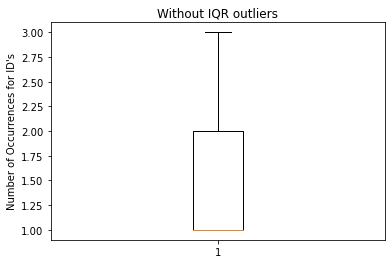

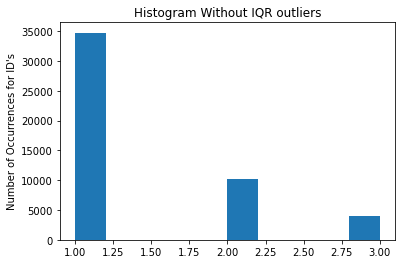

In [21]:
plt.boxplot(df.numOccurrences)
plt.ylabel("Number of Occurrences for ID's")
plt.title("Without IQR outliers")
plt.show()

plt.hist(df.numOccurrences)
plt.ylabel("Number of Occurrences for ID's")
plt.title("Histogram Without IQR outliers")
plt.show()

In [22]:
df.head()

,quotation,speaker,qids,date,numOccurrences,probas,urls,movie
0,"Dimple Kapadia and Clemence Poesy, the French ...",Dimple Kapadia,[Q158558],2019-05-24,1,"[[Dimple Kapadia, 0.749], [None, 0.1498], [Chr...",[https://www.bollywoodmantra.com/news/dimple-k...,Tenet
1,Dr. West brings significant healthcare experie...,None,[],2019-08-26,1,"[[None, 0.8808], [Edward A. Kangas, 0.1192]]",[https://healthcare.dmagazine.com/2019/08/26/t...,Tenet
2,It is a six pointer - we all know that. Hopefu...,John Askey,[Q6219624],2019-03-10,1,"[[John Askey, 0.4337], [Ricky Miller, 0.3332],...",[https://www.stokesentinel.co.uk/sport/footbal...,Onward
3,"What it will be called ultimately, I don't kno...",Matt Reeves,[Q931613],2019-05-17,1,"[[Matt Reeves, 0.8699], [None, 0.1065], [Ben A...",[https://comicbook.com/dc/2019/05/17/robert-pa...,Birds of Prey: And the Fantabulous Emancipatio...
4,Martin was the most important man in the ad wo...,Martin Sorrell,[],2019-06-21,1,"[[None, 0.6993], [Martin Sorrell, 0.3007]]",[https://pagesix.com/2019/06/21/disgraced-adve...,The Invisible Man


### Dealing with the quoter-IDs

Furthermore, we see that the `qids` might need some engineering. In the initial analyses on the 2019 NYT data we saw that some individuals are quoted differently even though it's in fact the same speaker. For instance this was the case for the speaker "Donald Trump" and "President Trump". In this case these two denotations share a common qID for which reason we would want to be able to get all quotes from Donald Trump and President Trump when searching for them independently. Even though it might not be as important with movies, we deem it good practice to regulate this behaviour. We start by engineering empty quoteID-lists as an unknown token.

In [23]:
empty = np.array([entry for entry, qID_list in enumerate(df.qids) if len(qID_list) == 0])
print(f"Number of currently unknown qids: {len(empty)}")

Number of currently unknown qids: 18781


In [24]:
pd.options.mode.chained_assignment = None
df['qids'][empty] = [['<UNK>']] * len(empty)

df.qids.head()

0     [Q158558]
1       [<UNK>]
2    [Q6219624]
3     [Q931613]
4       [<UNK>]
Name: qids, dtype: object

Using this '\<UNK>' token we are able to search the df to replace this token with a qID if the speaker occurs with a qID another place in the data. In this manner all qIDs of a specified speaker will be the full list of qIDs associated with that speaker.

In [25]:
def set_qID(speaker, df):
    #Extract qID's of a speaker
    qIDs = {speaker: list({quote_ID for quote_IDlist in df.qids[df['speaker'] == speaker] for quote_ID in quote_IDlist})}
    
    # Conditions for removing the <UNK> token.
    if len(qIDs[speaker]) > 1 and '<UNK>' in qIDs[speaker]:
        qIDs[speaker].remove('<UNK>')
    
    # Creating new qIDs for replacing in original dataframe
    speaker_indeces = np.where(df.speaker == speaker)[0]
    replacement = pd.Series([qIDs[speaker]] * (sum(df['speaker'] == speaker)), index=speaker_indeces)
    
    # Replace
    df.qids[df['speaker'] == speaker] = replacement

This now works, which can be seen on the speaker George Lucas in the following cells.

In [26]:
df[df.speaker == 'George Lucas'].head()

,quotation,speaker,qids,date,numOccurrences,probas,urls,movie
509,"When I started to go into Star Wars, [ my frie...",George Lucas,"[Q1507803, Q38222]",2015-12-31,1,"[[George Lucas, 0.7612], [Colin Trevorrow, 0.1...",[http://theindianrepublic.com/i-sold-star-wars...,Star Wars: Episode VII - The Force Awakens
523,"After `Star Wars,' I went back to Warner Bros....",George Lucas,"[Q1507803, Q38222]",2015-04-19,1,"[[George Lucas, 0.6949], [None, 0.1538], [Step...",[http://sfgate.com/technology/businessinsider/...,Star Wars: Episode VII - The Force Awakens
546,a Star Wars for girls,George Lucas,[<UNK>],2015-01-27,1,"[[None, 0.5037], [George Lucas, 0.4963]]",[http://www.comicmix.com/2015/01/27/box-office...,Star Wars: Episode VII - The Force Awakens
560,We became friends and then we started dating a...,George Lucas,"[Q1507803, Q38222]",2015-12-19,2,"[[George Lucas, 0.5894], [None, 0.4106]]",[http://feeds.businessinsider.com.au/~/1290472...,Star Wars: Episode VII - The Force Awakens
577,I might use the lightsaber instead of a torch ...,George Lucas,[<UNK>],2015-10-30,2,"[[None, 0.8296], [George Lucas, 0.1704]]",[http://dailyliberal.com.au/story/3459543/movi...,Star Wars: Episode VII - The Force Awakens


In [27]:
# Calling the function
set_qID('George Lucas', df)

df[df.speaker == 'George Lucas'].head()

,quotation,speaker,qids,date,numOccurrences,probas,urls,movie
509,"When I started to go into Star Wars, [ my frie...",George Lucas,"[Q1507803, Q38222]",2015-12-31,1,"[[George Lucas, 0.7612], [Colin Trevorrow, 0.1...",[http://theindianrepublic.com/i-sold-star-wars...,Star Wars: Episode VII - The Force Awakens
523,"After `Star Wars,' I went back to Warner Bros....",George Lucas,"[Q1507803, Q38222]",2015-04-19,1,"[[George Lucas, 0.6949], [None, 0.1538], [Step...",[http://sfgate.com/technology/businessinsider/...,Star Wars: Episode VII - The Force Awakens
546,a Star Wars for girls,George Lucas,"[Q1507803, Q38222]",2015-01-27,1,"[[None, 0.5037], [George Lucas, 0.4963]]",[http://www.comicmix.com/2015/01/27/box-office...,Star Wars: Episode VII - The Force Awakens
560,We became friends and then we started dating a...,George Lucas,"[Q1507803, Q38222]",2015-12-19,2,"[[George Lucas, 0.5894], [None, 0.4106]]",[http://feeds.businessinsider.com.au/~/1290472...,Star Wars: Episode VII - The Force Awakens
577,I might use the lightsaber instead of a torch ...,George Lucas,"[Q1507803, Q38222]",2015-10-30,2,"[[None, 0.8296], [George Lucas, 0.1704]]",[http://dailyliberal.com.au/story/3459543/movi...,Star Wars: Episode VII - The Force Awakens


We want to apply this functionality to the full dataframe (meaning all individual speakers) for which reason we extract the individual speaker names and how frequently quoted they are. We calculate the number of unique quotes for each speaker even though we find it more relevant to do outlier detection based on total number of occurences (`numOccurrences` attribute). This will be done later in the pipeline.

In [28]:
speakers, freq_unsorted = np.unique(df.speaker, return_counts=True)
freq, speakers = np.array(list(zip(*sorted(zip(freq_unsorted, speakers), reverse=True))))

print("Top 10 quoted speakers (w/o numOccurences): ")
list(zip(speakers[:10], freq[:10]))

Top 10 quoted speakers (w/o numOccurences): 


[('None', '7307'),
 ('Kevin Feige', '918'),
 ('Captain Marvel', '623'),
 ('Rian Johnson', '452'),
 ('Mark Hamill', '388'),
 ('George Lucas', '387'),
 ('Tom Holland', '384'),
 ('Patty Jenkins', '361'),
 ('Gal Gadot', '361'),
 ('J.J. Abrams', '356')]

In [29]:
for speaker in tqdm(speakers):
    set_qID(speaker, df=df)

  0%|          | 0/12856 [00:00<?, ?it/s]

Now, the only way there would be qID's of the name '\<UNK>' would be if the assignment of the predicted speaker is less than 15% percent certain (see `proba_threshhold` in the removal of None-type speakers) and if that same speaker does not have a qID throughout all of the dataframe. In this case we find evidence for deleting the rows.

In [30]:
UNK_idxs = np.array([], dtype=int)
for i, qID in enumerate(tqdm(df.qids)):
    if '<UNK>' in qID:
        UNK_idxs = np.append(UNK_idxs, i)

  0%|          | 0/48849 [00:00<?, ?it/s]

In [31]:
df = df.drop(UNK_idxs)
df.index = np.arange(len(df))
df.shape

(37960, 8)

The following function then concatenates the qID's of speakers if they have more than one qID in common, such that we get exactly the basis for a shared ID if two speakers (like Donald Trump and President Trump) are in fact the same.

In [32]:
def mergeQuoteIDs(df):
    qID_dict = defaultdict(dict)
    print("Creating qID dictionary...")
    for document_number, qid_list in enumerate(tqdm(df.qids)):
        for qid in qid_list:
            if qid in qID_dict:
                qID_dict[qid].append(document_number)
            else:
                qID_dict[qid] = [document_number]
    
    print("Gathering qIDs across documents...")
    new_column = {}
    for document_number, qid_list in enumerate(tqdm(df.qids)):
        document_IDs = []
        for qid in qid_list:
            document_IDs.append(qID_dict[qid])

        related_docs = set(np.concatenate(document_IDs))
        new_qids = list(set(np.concatenate(list(df.qids[related_docs]))))

        new_column[document_number] = new_qids

    df['qids'] = pd.Series(new_column)

In [33]:
mergeQuoteIDs(df)
df.head()

Creating qID dictionary...


  0%|          | 0/37960 [00:00<?, ?it/s]

Gathering qIDs across documents...


  0%|          | 0/37960 [00:00<?, ?it/s]

,quotation,speaker,qids,date,numOccurrences,probas,urls,movie
0,"Dimple Kapadia and Clemence Poesy, the French ...",Dimple Kapadia,[Q158558],2019-05-24,1,"[[Dimple Kapadia, 0.749], [None, 0.1498], [Chr...",[https://www.bollywoodmantra.com/news/dimple-k...,Tenet
1,It is a six pointer - we all know that. Hopefu...,John Askey,[Q6219624],2019-03-10,1,"[[John Askey, 0.4337], [Ricky Miller, 0.3332],...",[https://www.stokesentinel.co.uk/sport/footbal...,Onward
2,"What it will be called ultimately, I don't kno...",Matt Reeves,[Q931613],2019-05-17,1,"[[Matt Reeves, 0.8699], [None, 0.1065], [Ben A...",[https://comicbook.com/dc/2019/05/17/robert-pa...,Birds of Prey: And the Fantabulous Emancipatio...
3,Japanese Tales 1: The Invisible Man,Yuko Shimizu,"[Q8060791, Q464270]",2019-04-01,1,"[[Yuko Shimizu, 0.7893], [None, 0.157], [Ruth ...",[https://locusmag.com/2019/04/spectrum-26-awar...,The Invisible Man
4,I knew about Birds of Prey. I was really excit...,Juliana Harkavy,[Q16223655],2019-04-15,2,"[[Juliana Harkavy, 0.9075], [None, 0.083], [Em...",[https://comicbook.com/2019/04/15/juliana-hark...,Birds of Prey: And the Fantabulous Emancipatio...


And then we create a new ID for each unique list of qID's.

In [34]:
def newID(df):
    unique_IDlists = np.unique(df['qids'])
    newIDs = []
    
    for row_qIDlist in tqdm(df.qids):
        for newID, unique_list in enumerate(unique_IDlists):
            if unique_list == row_qIDlist:
                newIDs.append(newID)
    df['shared_ID'] = newIDs
    
    return newIDs

In [35]:
newIDs = newID(df)

  0%|          | 0/37960 [00:00<?, ?it/s]

In [36]:
df.head()

,quotation,speaker,qids,date,numOccurrences,probas,urls,movie,shared_ID
0,"Dimple Kapadia and Clemence Poesy, the French ...",Dimple Kapadia,[Q158558],2019-05-24,1,"[[Dimple Kapadia, 0.749], [None, 0.1498], [Chr...",[https://www.bollywoodmantra.com/news/dimple-k...,Tenet,755
1,It is a six pointer - we all know that. Hopefu...,John Askey,[Q6219624],2019-03-10,1,"[[John Askey, 0.4337], [Ricky Miller, 0.3332],...",[https://www.stokesentinel.co.uk/sport/footbal...,Onward,7791
2,"What it will be called ultimately, I don't kno...",Matt Reeves,[Q931613],2019-05-17,1,"[[Matt Reeves, 0.8699], [None, 0.1065], [Ben A...",[https://comicbook.com/dc/2019/05/17/robert-pa...,Birds of Prey: And the Fantabulous Emancipatio...,9480
3,Japanese Tales 1: The Invisible Man,Yuko Shimizu,"[Q8060791, Q464270]",2019-04-01,1,"[[Yuko Shimizu, 0.7893], [None, 0.157], [Ruth ...",[https://locusmag.com/2019/04/spectrum-26-awar...,The Invisible Man,9349
4,I knew about Birds of Prey. I was really excit...,Juliana Harkavy,[Q16223655],2019-04-15,2,"[[Juliana Harkavy, 0.9075], [None, 0.083], [Em...",[https://comicbook.com/2019/04/15/juliana-hark...,Birds of Prey: And the Fantabulous Emancipatio...,1015


### Investigating the new ID's

We will now investigate how different ID's (the shared one) are distributed across quotes. We calculate the frequency with which ID is associated, meaning the total number of occurences for each ID.

In [37]:
print(f"Number of unique IDs: {np.max(df.shared_ID)}")

Number of unique IDs: 9602


In [38]:
freq_occurences = defaultdict(dict)

for ID in tqdm(newIDs):
    freq_occurences[ID] = sum(df[df['shared_ID'] == ID].numOccurrences)

  0%|          | 0/37960 [00:00<?, ?it/s]

In [39]:
freq_list = [(ID, count) for ID, count in sorted(freq_occurences.items(), key=lambda item: item[1], reverse=True)]
ID, freq = list(zip(*freq_list))
ID, freq = np.array(ID), np.array(freq)

Using a boxplot we also see that these ones seem to be full of outliers and by plotting the amount of occurrences with the speakers sorted in a descending manner, we see that the distribution looks like a strong power law.

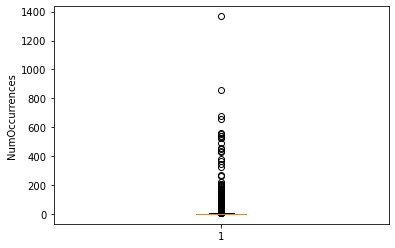

In [40]:
plt.boxplot(freq)
plt.ylabel("NumOccurrences")
plt.show()

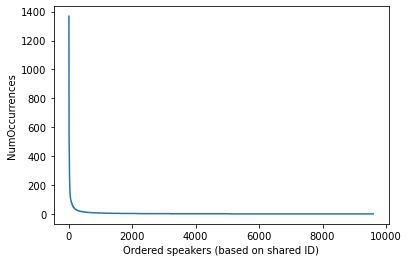

In [41]:
plt.plot(np.arange(len(freq)), freq)
plt.xlabel("Ordered speakers (based on shared ID)")
plt.ylabel("NumOccurrences")
plt.show()

We do not regard this as a problem, since it seems reasonable that this depicts the real-world scenario where some people - like star directors and movie stars - have more to say than actors that are not playing in movies at the current time but still gets quoted once in a while.

By looking at the shared_ID, we now see that the ambiguity of speakers is now reduced - which will be useful in further analyses - as the new `shared_ID` attribute captures identical speaker denoted by different names.

In [42]:
N = 25
topN = []

print(f"Most quoted ID's: \n (shared_ID, total numOccurrences, associated speakers)\n")
for n in range(N):
    
    idxs = [i for (i, shared) in enumerate(df.shared_ID) if shared == ID[n]]
    associated_speakers = df.iloc[idxs, :].speaker.unique()
    
    info_tuple = (ID[n], freq[n], list(associated_speakers))
    topN.append(info_tuple)
    
    print(f"{n+1}) {topN[n]}\n")

Most quoted ID's: 
 (shared_ID, total numOccurrences, associated speakers)

1) (6215, 1368, ['Kevin Feige', 'KEVIN FEIGE'])

2) (4916, 861, ['Captain Marvel', 'CAPTAIN MARVEL'])

3) (1710, 679, ['J.J. Abrams', 'JJ Abrams', 'J. J. Abrams', 'jj abrams', 'J J Abrams', 'J.J. ABRAMS'])

4) (7790, 656, ['Rian Johnson', 'RIAN JOHNSON'])

5) (2041, 564, ['Tom Holland'])

6) (2219, 556, ['Mark Hamill', 'MARK HAMILL'])

7) (5284, 539, ['Patty Jenkins', 'PATTY JENKINS', 'patty Jenkins'])

8) (629, 538, ['George Lucas', 'GEORGE LUCAS'])

9) (1630, 528, ['Gal Gadot'])

10) (6593, 526, ['Bob Iger', 'Robert Iger', 'Robert A. Iger'])

11) (2751, 491, ['Kathleen Kennedy'])

12) (1118, 459, ['Robert Downey Jr. .', 'Robert Downey', 'ROBERT DOWNEY JR. .'])

13) (1268, 450, ['Joe Russo', 'Joseph Russo'])

14) (1290, 434, ['John Boyega'])

15) (2276, 432, ['Peter Parker'])

16) (2807, 381, ['Taika Waititi', 'TAIKA WAITITI'])

17) (6738, 368, ['Chris Hemsworth', 'chris hemsworth', 'CHRIS HEMSWORTH'])

18) (1

### Add sentiment of quotes

We use the `Afinn` sentiment lexicon for mapping a sentiment score to each quote in the preprocessed Quotebank data.

In [43]:
!pip install Afinn
from afinn import Afinn

     |████████████████████████████████| 52 kB 2.2 MB/s eta 0:00:011
  Created wheel for Afinn: filename=afinn-0.1-py3-none-any.whl size=53448 sha256=7a4450d95c5d9d0f52caf4dcf9e4f3008eb7f8d8a5000134da59b9035f7daa09
  Stored in directory: /Users/Julian/Library/Caches/pip/wheels/f6/6f/c3/b305c5107a17618f2938a067d5ffcbb556909d82398762089e
Successfully built Afinn


In [44]:
afn = Afinn()
sentiments = [afn.score(quote) for quote in tqdm(df.quotation)]
df['sentiment'] = sentiments

  0%|          | 0/37960 [00:00<?, ?it/s]

And now we see the average, max, min, etc. of the attribute.

In [45]:
df.sentiment.describe()

count    37960.000000
mean         2.524236
std          5.681937
min        -45.000000
25%          0.000000
50%          1.000000
75%          5.000000
max         89.000000
Name: sentiment, dtype: float64

The dataframe is saved as a pickle and we investigate the sentiment further in the `sentiment.ipynb` file.

In [48]:
# Save loaded DataFrame as pickle for faster loading time in the future
df.to_pickle(rf"{data_dir}/Quotebank_wSentiment.pkl")
print(f"Dataframe was pickled and saved to directory:\n" + data_dir)

Dataframe was pickled and saved to directory:
/Users/Julian/Documents/Studium/WS21_22/ada-2021-project-f-jab/data


In [47]:
N = len(df)-1
topN = []

print(f"Most quoted ID's: \n (shared_ID, total numOccurrences, associated speakers)\n")
for n in range(N):
    
    idxs = [i for (i, shared) in enumerate(df.shared_ID) if shared == ID[n]]
    associated_speakers = df.iloc[idxs, :].speaker.unique()
    
    info_tuple = (ID[n], freq[n], list(associated_speakers))
    topN.append(info_tuple)
    
    print(f"{n+1}) {topN[n]}\n")

Most quoted ID's: 
 (shared_ID, total numOccurrences, associated speakers)

1) (6215, 1368, ['Kevin Feige', 'KEVIN FEIGE'])

2) (4916, 861, ['Captain Marvel', 'CAPTAIN MARVEL'])

3) (1710, 679, ['J.J. Abrams', 'JJ Abrams', 'J. J. Abrams', 'jj abrams', 'J J Abrams', 'J.J. ABRAMS'])

4) (7790, 656, ['Rian Johnson', 'RIAN JOHNSON'])

5) (2041, 564, ['Tom Holland'])

6) (2219, 556, ['Mark Hamill', 'MARK HAMILL'])

7) (5284, 539, ['Patty Jenkins', 'PATTY JENKINS', 'patty Jenkins'])

8) (629, 538, ['George Lucas', 'GEORGE LUCAS'])

9) (1630, 528, ['Gal Gadot'])

10) (6593, 526, ['Bob Iger', 'Robert Iger', 'Robert A. Iger'])

11) (2751, 491, ['Kathleen Kennedy'])

12) (1118, 459, ['Robert Downey Jr. .', 'Robert Downey', 'ROBERT DOWNEY JR. .'])

13) (1268, 450, ['Joe Russo', 'Joseph Russo'])

14) (1290, 434, ['John Boyega'])

15) (2276, 432, ['Peter Parker'])

16) (2807, 381, ['Taika Waititi', 'TAIKA WAITITI'])

17) (6738, 368, ['Chris Hemsworth', 'chris hemsworth', 'CHRIS HEMSWORTH'])

18) (1

202) (8353, 33, ['Michael Pachter'])

203) (9486, 33, ['Drew Struzan'])

204) (3160, 33, ['Jeremy Latcham'])

205) (4709, 33, ['Natalie Portman'])

206) (1721, 33, ['Sam Witwer'])

207) (8622, 33, ['Peter Quill'])

208) (3499, 33, ['Ryan Meinerding'])

209) (8584, 33, ['Paul Wernick'])

210) (3170, 32, ['Joe Quesada'])

211) (4017, 32, ['Damon Lindelof'])

212) (8807, 32, ['Robbie Collin'])

213) (3604, 32, ['Steve Weintraub', 'Steven Weintraub'])

214) (1461, 32, ['Greg Rucka'])

215) (856, 32, ['Jim Lee'])

216) (273, 32, ['Peter ?'])

217) (3690, 32, ['Hillary Ronen'])

218) (4689, 32, ['Venkaiah Naidu'])

219) (510, 32, ['Ryan Smith'])

220) (5678, 31, ['Ava DuVernay', 'Ava Duvernay'])

221) (614, 31, ['Tim Lucas'])

222) (5664, 31, ['Doug Chiang'])

223) (2715, 31, ['Michael Phillips'])

224) (5675, 31, ['Brian Goldner'])

225) (4366, 31, ['Idris Elba'])

226) (375, 31, ['Hugh Jackman'])

227) (9114, 31, ['Kirsten Dunst'])

228) (4133, 31, ['Jeremy Tucker'])

229) (8914, 31, ['Sal

420) (725, 16, ['Naomie Harris'])

421) (443, 16, ['Peter Moore'])

422) (2616, 16, ['Bryce Dallas Howard'])

423) (3512, 16, ['Kiri Hart'])

424) (4252, 16, ['Max Landis'])

425) (3876, 16, ['Roger Moore'])

426) (6714, 16, ['Mindy Kaling'])

427) (11, 16, ['Kurt Russell'])

428) (1385, 16, ['Jessica Jones'])

429) (4222, 16, ['Jeff Pinkner'])

430) (4006, 16, ['Justin Trudeau'])

431) (3456, 16, ['John Blackburn'])

432) (704, 16, ['Michael Giacchino'])

433) (9267, 16, ['Trevor Noah'])

434) (995, 16, ['Ian Doescher'])

435) (8073, 16, ['Jim Cramer'])

436) (5787, 16, ['Bilge Ebiri'])

437) (9503, 16, ['Grant Morrison'])

438) (5174, 16, ['Frank Gibeau'])

439) (4712, 16, ['Edgar Wright'])

440) (7303, 16, ['Marco Checchetto'])

441) (2020, 16, ['Blade Runner'])

442) (8978, 16, ['Sebastian Gorka'])

443) (2154, 16, ['Frank Miller'])

444) (2764, 16, ['Aaryn Flynn', 'Aaryn FLynn'])

445) (3945, 16, ['Jack Posobiec'])

446) (5841, 16, ['Bob Martin'])

447) (8045, 16, ['Kevin Thornton

644) (6289, 11, ['Chris Avellone'])

645) (8483, 11, ['Tom DeFalco'])

646) (6784, 11, ['Bobby Seale'])

647) (2440, 11, ['Amitabh Kant'])

648) (1904, 11, ['Yemi Osinbajo'])

649) (2495, 11, ['Jaden Smith'])

650) (3352, 11, ['Maneka Gandhi'])

651) (7671, 11, ['Jean Arnault'])

652) (9517, 11, ['Sachin Tendulkar'])

653) (4832, 11, ['Ruth E. Carter'])

654) (6191, 11, ['Clay Enos'])

655) (9271, 11, ['Tom Taylor', 'TOM TAYLOR'])

656) (2694, 11, ['Michael James Scott'])

657) (7429, 11, ['Jack Nicholson'])

658) (2248, 10, ['Christina Hodson'])

659) (4877, 10, ['Jim Carrey'])

660) (959, 10, ['Elton John'])

661) (529, 10, ['Holly Willoughby'])

662) (3640, 10, ['Brian Lowry'])

663) (7714, 10, ['Tom Stone'])

664) (7832, 10, ['John Hsu'])

665) (2714, 10, ['Joe Morgenstern'])

666) (4759, 10, ['Dave Franco'])

667) (7682, 10, ['Jeff Hickman'])

668) (4683, 10, ['Gary Barber'])

669) (4799, 10, ['Daniel Miller'])

670) (9481, 10, ['Juan Antonio Bayona', 'J. A. Bayona'])

671) (2797,

874) (3737, 8, ['Jeremy Corbyn'])

875) (8996, 8, ['Sharad Devarajan'])

876) (2742, 8, ['Roy Price'])

877) (8652, 8, ['Doug Wilson'])

878) (9202, 8, ['Tim Walsh'])

879) (5505, 8, ['Amanda Nevill'])

880) (4818, 8, ['Steve Blank'])

881) (1295, 8, ['John Mollo'])

882) (1729, 8, ['Lauren Jauregui'])

883) (4512, 8, ['Bruce Dern'])

884) (237, 8, ['Joe Girardi'])

885) (1764, 8, ['Marisa Tomei'])

886) (692, 8, ['Vikramaditya Motwane'])

887) (6090, 8, ['Chris Baker'])

888) (2479, 8, ['Matt Martin'])

889) (8952, 8, ['Scott Pruitt'])

890) (4019, 8, ['Gina Prince-Bythewood'])

891) (5982, 8, ['David Benioff'])

892) (2530, 8, ['Stanley Tucci'])

893) (8590, 8, ['Martin Starr'])

894) (8283, 8, ['Matt Miller'])

895) (6601, 8, ['Ed Orgeron'])

896) (5826, 8, ['Bob Baffert'])

897) (2149, 8, ['Peter Yeo'])

898) (5626, 8, ['Anna Brown'])

899) (8941, 8, ['Scott Coker'])

900) (8656, 8, ['Piyush Goyal'])

901) (2121, 8, ['Tomi Lahren'])

902) (3016, 8, ['Ernesto Abella'])

903) (4652, 

1108) (7069, 6, ['Dana Goldberg'])

1109) (4359, 6, ['Justin Bieber'])

1110) (3684, 6, ['Kate McCarthy'])

1111) (8632, 6, ['Peter Young'])

1112) (4539, 6, ['David Walliams'])

1113) (8635, 6, ['Bob Newhart'])

1114) (2087, 6, ['Kyle Balda'])

1115) (6978, 6, ['Chris Williams'])

1116) (3284, 6, ['Jordan Randall'])

1117) (1626, 6, ['Andy Palmer'])

1118) (1065, 6, ['Mackenzie Davis'])

1119) (6015, 6, ['Biz Markie'])

1120) (4624, 6, ['Jackie Chan'])

1121) (9046, 6, ['Stephen Dalton'])

1122) (3327, 6, ['Jason McGatlin'])

1123) (5178, 6, ['Franz Beckenbauer'])

1124) (2329, 6, ['James Armstrong'])

1125) (6449, 6, ['David Sims'])

1126) (8487, 6, ['Noah Hawley'])

1127) (7056, 6, ['Grae Drake'])

1128) (9065, 6, ['Steve Evans'])

1129) (6098, 6, ['Chris Brown'])

1130) (3547, 6, ['Charlie Ross'])

1131) (6213, 6, ['Sara Stewart'])

1132) (8876, 6, ['Ross Miller'])

1133) (2377, 6, ['Immanuel Baptist Church'])

1134) (6597, 6, ['Andrew Fisher'])

1135) (5370, 6, ['Adam Blackwell'])

1339) (9156, 5, ['Andrew Kreisberg'])

1340) (5325, 5, ['Heitor Pereira'])

1341) (9535, 5, ['James Luceno'])

1342) (2247, 5, ['Don Granger'])

1343) (1954, 5, ['Ketan Patel'])

1344) (4907, 5, ['Pat Marshall'])

1345) (4440, 5, ['Paul Levitz'])

1346) (7396, 5, ['Kate Muir'])

1347) (2068, 5, ['Patrick Ness'])

1348) (1337, 5, ['Carles Puyol'])

1349) (3671, 5, ['Tony Chambers'])

1350) (7167, 5, ['Heather Brewer', 'Zac Brewer'])

1351) (874, 5, ['Chen Tien'])

1352) (9532, 5, ['Cass Sunstein'])

1353) (5386, 5, ['Raul Castro'])

1354) (7068, 5, ['Israel Sánchez'])

1355) (4785, 5, ['Richard Corliss'])

1356) (7270, 5, ['Alan Dean Foster'])

1357) (6220, 5, ['William Friedkin', 'WILLIAM FRIEDKIN'])

1358) (262, 5, ['Graham Young'])

1359) (1969, 5, ['Jenna Busch'])

1360) (8943, 5, ['Scott Dunbier'])

1361) (3214, 5, ['Jason Lyle Black', 'Jason Black'])

1362) (3183, 5, ['Wil Wheaton'])

1363) (6403, 5, ['David Harris'])

1364) (7916, 5, ['Josh Earnest'])

1365) (4783, 5, ['Donny Osm

1566) (4824, 5, ['Zahir Tanin'])

1567) (3189, 5, ['Antonio Conte'])

1568) (8811, 5, ['Robert B. Pamplin'])

1569) (6604, 5, ['Ed Skrein'])

1570) (1836, 5, ['Reilly Brown'])

1571) (3970, 5, ['Eric Foner'])

1572) (7428, 5, ['Bob Johnson', 'Robert Johnson'])

1573) (435, 5, ['Rocky Anderson'])

1574) (8752, 5, ['Rich Moore'])

1575) (7593, 5, ['James Cason'])

1576) (8885, 5, ['Ed Brubaker'])

1577) (5681, 5, ['Ayan Mukerji'])

1578) (6459, 5, ['David Walker'])

1579) (6960, 5, ['James Robertson'])

1580) (3488, 5, ['Walter Scott'])

1581) (6725, 5, ['Evan Schwartz'])

1582) (3709, 5, ['Kaitlin Olson'])

1583) (2191, 5, ['Grace Randolph'])

1584) (7106, 5, ['Jim Cummings'])

1585) (4403, 5, ['Gaspar Noé', 'Gaspar Noe'])

1586) (3482, 5, ['Darren Franich'])

1587) (7143, 5, ['Chris Caldwell'])

1588) (6591, 5, ['Toby Haynes'])

1589) (1558, 5, ['Joey Bosa'])

1590) (5381, 5, ['Adam Rex'])

1591) (4192, 5, ['Larry Fink'])

1592) (8736, 5, ['Reed Hastings'])

1593) (7812, 5, ['John Dill

1796) (6439, 4, ['David Clarke'])

1797) (9269, 4, ['Troy Grant'])

1798) (4974, 4, ['Simon Webster'])

1799) (1079, 4, ['Nilesh Patel'])

1800) (3196, 4, ['Nicholas Hammond'])

1801) (1368, 4, ['Joanne Clifton'])

1802) (782, 4, ['John Holt'])

1803) (3411, 4, ['Beth Elderkin'])

1804) (7369, 4, ['Joseph Schmidt'])

1805) (6472, 4, ['DeShawn Shead', 'Deshawn Shead'])

1806) (9394, 4, ['Dane DeHaan'])

1807) (3942, 4, ['Wayne Nichols'])

1808) (1615, 4, ['Ian Thorpe'])

1809) (6483, 4, ['Michael Rooker'])

1810) (7218, 4, ['Dan Haley'])

1811) (9142, 4, ['Teresa Morgan'])

1812) (6438, 4, ['David Rooney'])

1813) (3105, 4, ['krysten ritter', 'Krysten Ritter'])

1814) (4687, 4, ['Angela Simpson'])

1815) (8893, 4, ['Ryan Blaney'])

1816) (9031, 4, ['Spencer Wilding'])

1817) (6050, 4, ['Rachel Talalay'])

1818) (4188, 4, ['Dick Vitale'])

1819) (8808, 4, ['Robbie Thompson'])

1820) (8033, 4, ['Kevin Gorman'])

1821) (7522, 4, ['Mario Hernandez'])

1822) (942, 4, ['Kevin Clifton'])

1823

2029) (5961, 4, ['Joe Dempsie'])

2030) (4990, 4, ['Angel Parker'])

2031) (1822, 4, ['Mr. Sam'])

2032) (8065, 4, ['Komatireddy Venkat Reddy'])

2033) (7022, 4, ['William Baker'])

2034) (778, 4, ['Jean-Pierre Lacroix'])

2035) (8649, 4, ['Nana Akufo-Addo'])

2036) (1528, 4, ['Bruce Smith'])

2037) (2725, 4, ['Peggy Whitson'])

2038) (3323, 4, ['Sanjeev Sharma'])

2039) (1222, 4, ['David F. Sandberg'])

2040) (3442, 4, ['Thomas Zurbuchen'])

2041) (6357, 4, ['Dave Palmer'])

2042) (7689, 4, ['Jeff Parker'])

2043) (6172, 4, ['Phil Collen'])

2044) (8234, 4, ['Mark Ritchie'])

2045) (8787, 4, ['Rico Petrocelli'])

2046) (8594, 4, ['Pete Ashdown'])

2047) (2291, 4, ['John Friend'])

2048) (8362, 4, ['Michael Symon'])

2049) (1071, 4, ['Jorge Navarro'])

2050) (9185, 4, ['Tim Graham'])

2051) (2460, 4, ['Dilip Ghosh'])

2052) (7625, 4, ['Jamie Hendry'])

2053) (4203, 4, ['Daymond John'])

2054) (2281, 4, ['Shehu Sani'])

2055) (188, 4, ['James Stavridis'])

2056) (8159, 4, ['Luke McDonne

2257) (6952, 3, ['Glen Powell'])

2258) (3660, 3, ['Lena Dunham'])

2259) (4235, 3, ['Ed Helms'])

2260) (775, 3, ['Richard Baker'])

2261) (6274, 3, ['Jean Wyllys'])

2262) (7041, 3, ['Linda Holmes'])

2263) (3669, 3, ['Scott Allen'])

2264) (4574, 3, ['Sajid Nadiadwala'])

2265) (6469, 3, ['Jay Roach'])

2266) (3633, 3, ['David Dziurzynski'])

2267) (4120, 3, ['Chiwetel Ejiofor'])

2268) (568, 3, ['Tina Fey'])

2269) (4551, 3, ['Ray Park'])

2270) (9365, 3, ['Ben Carson'])

2271) (4636, 3, ['Raul Ruiz'])

2272) (740, 3, ['Eugenie Bondurant'])

2273) (1448, 3, ['Kenneth Lacovara'])

2274) (2046, 3, ['Kate Winslet'])

2275) (1959, 3, ['Anthony Anderson'])

2276) (8509, 3, ['Oliver Thornton'])

2277) (4184, 3, ['Grant Imahara'])

2278) (1908, 3, ['Charlie Puth'])

2279) (8569, 3, ['Paul Jones'])

2280) (361, 3, ['Mark Kermode'])

2281) (4428, 3, ['Steve Burke'])

2282) (7544, 3, ['Tommy Rydling'])

2283) (6288, 3, ['Dacher Keltner'])

2284) (6755, 3, ['Ty Simpkins'])

2285) (3957, 3, ['

2497) (9518, 3, ['Larry Joe Campbell'])

2498) (4647, 3, ['Gerard Gallant'])

2499) (8269, 3, ['Mathew Cullen'])

2500) (7252, 3, ['Eric Wells'])

2501) (2970, 3, ['Ryan Parker'])

2502) (6264, 3, ['Nicola Thorp'])

2503) (6871, 3, ['Gary Hailes'])

2504) (5788, 3, ['Wolf Blitzer'])

2505) (5305, 3, ['Joe Morton'])

2506) (7584, 3, ['Jake Zim'])

2507) (944, 3, ['Eric Goldman'])

2508) (6827, 3, ['Lisa Miller'])

2509) (3843, 3, ['Djimon Hounsou'])

2510) (8083, 3, ['Landon Collins'])

2511) (2221, 3, ['Aubrey Plaza'])

2512) (9171, 3, ['Thomas Rhett'])

2513) (1520, 3, ['Rhys Darby'])

2514) (4201, 3, ['Logan Couture'])

2515) (6580, 3, ['Jim Boeheim'])

2516) (8927, 3, ['Santokh Singh'])

2517) (6524, 3, ['Guy Henry'])

2518) (5954, 3, ['Caleb King'])

2519) (7513, 3, ['Luis Contreras'])

2520) (1878, 3, ['Pamela Redmond Satran'])

2521) (971, 3, ['Jessie Graff'])

2522) (8806, 3, ['Rob Tweedie'])

2523) (5133, 3, ['Stacey Solomon'])

2524) (2723, 3, ['Connie Britton'])

2525) (199, 

2729) (837, 3, ['Ishwar Singh'])

2730) (1472, 3, ['Stephen Cone'])

2731) (8109, 3, ['Len McCluskey'])

2732) (4937, 3, ['Cyril Aouizerate'])

2733) (9052, 3, ['Steve Anderson'])

2734) (7470, 3, ['Martin Fisher'])

2735) (1405, 3, ['Andrew Welch'])

2736) (1208, 3, ['Sacha Jenkins'])

2737) (5083, 3, ['Jon West'])

2738) (7542, 3, ['Liu Cixin'])

2739) (6921, 3, ['George Young'])

2740) (3852, 3, ['Jane Glover'])

2741) (247, 3, ['Derek Hough'])

2742) (6864, 3, ['Gary Dolphin'])

2743) (1516, 3, ['Seth Moulton'])

2744) (9153, 3, ['Bob Bergen'])

2745) (4895, 3, ['Daniel Lee'])

2746) (2869, 3, ['KJ Apa'])

2747) (2517, 3, ['Keegan Rosenberry'])

2748) (540, 3, ['Lori McCreary'])

2749) (1077, 3, ['John Currie'])

2750) (1949, 3, ['Mark Stockdale'])

2751) (5666, 3, ['Ashleigh Sykes'])

2752) (6743, 3, ['John August'])

2753) (7006, 3, ['Grant Smillie'])

2754) (7875, 3, ['Johnny Lee'])

2755) (6123, 3, ['Chris McKenna'])

2756) (1595, 3, ['Don Parkinson'])

2757) (6673, 3, ['Eric E

2967) (1424, 3, ['Diane Corner'])

2968) (7082, 3, ['Halima Ahmed'])

2969) (8608, 3, ['Peter Drummond'])

2970) (5130, 3, ['James Hogg'])

2971) (8278, 3, ['Matt Hanson'])

2972) (9033, 3, ['Stacey Snider'])

2973) (9054, 3, ['Stephen Miller'])

2974) (5860, 3, ['Borzou Daragahi'])

2975) (6776, 3, ['Rick Barba'])

2976) (8413, 3, ['Mike Sterner'])

2977) (8333, 3, ['Michael Fath'])

2978) (5237, 3, ['John Billingsley'])

2979) (2841, 3, ['Tom Robertson'])

2980) (8756, 3, ['Richard Carwardine'])

2981) (9132, 3, ['Tanmay Bhat'])

2982) (8547, 3, ['Patrick Kelly'])

2983) (3628, 3, ['Louis Masur'])

2984) (2919, 3, ['Tom Marino'])

2985) (7771, 3, ['Joe Kelly'])

2986) (4421, 3, ['Adam Hochschild'])

2987) (3886, 3, ['James E. Campbell'])

2988) (4423, 3, ['Stephanie Rawlings-Blake'])

2989) (4806, 3, ['Owen Smith'])

2990) (8467, 3, ['John Yarmuth'])

2991) (3896, 3, ['John Andrew'])

2992) (352, 3, ['David Kollar'])

2993) (3985, 3, ['Blake Lee'])

2994) (8713, 3, ['Ralph Peters'])



3197) (1384, 2, ['Masato Nakamura'])

3198) (2144, 2, ['Peter Cramer'])

3199) (6939, 2, ['Gil Student'])

3200) (4549, 2, ['Alex Gray'])

3201) (8937, 2, ['Scott Baldwin'])

3202) (2546, 2, ['Buzz Aldrin'])

3203) (4445, 2, ['Suresh Raina'])

3204) (3655, 2, ['Kevin Murphy'])

3205) (7839, 2, ['John Kiriakou'])

3206) (3263, 2, ['David Spencer'])

3207) (8624, 2, ['Peter Safran'])

3208) (1066, 2, ['Lance Stroll'])

3209) (4858, 2, ['Tony Mendez'])

3210) (5705, 2, ['James Marsden'])

3211) (3943, 2, ['Bhuvan Bam'])

3212) (6993, 2, ['Graham Wilson'])

3213) (1927, 2, ['Ray Nowosielski'])

3214) (5760, 2, ['Ben Schwartz'])

3215) (4372, 2, ['Paul Curran'])

3216) (812, 2, ['William Gray'])

3217) (7080, 2, ['Hakeem Jeffries'])

3218) (212, 2, ['David Gottlieb'])

3219) (1756, 2, ['Brian Clemens'])

3220) (2250, 2, ['Ariel Gibilaro'])

3221) (8064, 2, ['Komal Nahta'])

3222) (9568, 2, ['Jim Cooper'])

3223) (5809, 2, ['Bill Shorten'])

3224) (1256, 2, ['Tom Bernard'])

3225) (83, 2, [

3434) (7512, 2, ['Ian Stuart'])

3435) (5309, 2, ['B.J. Novak'])

3436) (7493, 2, ['Adnan Baig'])

3437) (3044, 2, ['Saif Ali Khan'])

3438) (1469, 2, ['Sean Maguire'])

3439) (5831, 2, ['Bob DeSimone'])

3440) (1625, 2, ['Emily Tucker'])

3441) (7410, 2, ['Joseph Bernstein'])

3442) (8636, 2, ['Dr Brown'])

3443) (7083, 2, ['Sarah Fortune'])

3444) (617, 2, ['Jack Little'])

3445) (462, 2, ['Sloane Crosley'])

3446) (7980, 2, ['Robbie Moore'])

3447) (5564, 2, ['Andrea Smith'])

3448) (1257, 2, ['Christopher Townsend'])

3449) (4620, 2, ['Sam Mercer'])

3450) (5037, 2, ['Sarah Palin'])

3451) (1668, 2, ['Ian Martin'])

3452) (3594, 2, ['Ian Robertson'])

3453) (1413, 2, ['Kezia Dugdale'])

3454) (9039, 2, ['Stephen A. Smith'])

3455) (3468, 2, ['Robert Stewart'])

3456) (5708, 2, ['Barry Cohen'])

3457) (2239, 2, ['GAVIN JAMES'])

3458) (3925, 2, ['Aaron Huey'])

3459) (3004, 2, ['Lou Ferrigno'])

3460) (3372, 2, ['David Gross'])

3461) (5580, 2, ['Andrew Lindsay'])

3462) (7561, 2, [


3671) (4677, 2, ['Corey Feldman'])

3672) (2929, 2, ['Chris Jones'])

3673) (6499, 2, ['Derek Blasberg'])

3674) (6477, 2, ['Jonathan Lynn'])

3675) (8460, 2, ['Neiko Thorpe'])

3676) (2162, 2, ['Anderson . Paak'])

3677) (7273, 2, ['Eddie Kane'])

3678) (2335, 2, ['Anthony Atkinson'])

3679) (1866, 2, ['Lenore Manderson'])

3680) (6116, 2, ['Chris Lilley'])

3681) (554, 2, ['Qiu Zhijie'])

3682) (6751, 2, ['Angus King'])

3683) (2150, 2, ['Robert Barnes'])

3684) (3079, 2, ['Steve Hansen'])

3685) (5474, 2, ['Alex Green'])

3686) (6980, 2, ['Chris Wilcox'])

3687) (8865, 2, ['Ronald A. Bosco'])

3688) (1201, 2, ['Edwin Reyes'])

3689) (3588, 2, ['Rüdiger Bieler'])

3690) (3811, 2, ['Alfred Molina'])

3691) (8446, 2, ['Nasty Canasta'])

3692) (733, 2, ['Ashley Lawrence'])

3693) (1870, 2, ['Jorge Vidal'])

3694) (1508, 2, ['Tevin Coleman'])

3695) (6241, 2, ['Cory Hall'])

3696) (560, 2, ['Nnamdi Asomugha'])

3697) (5326, 2, ['Jordan Sinclair'])

3698) (7166, 2, ['Pascal Dupuis'])

36

3910) (8052, 2, ['Kim Johnson'])

3911) (2048, 2, ['David Watson'])

3912) (4589, 2, ['Phillip Dutton'])

3913) (8395, 2, ['Mike Kunkel'])

3914) (4811, 2, ['Emily Smith'])

3915) (2548, 2, ['Cardinal Dolan'])

3916) (1987, 2, ["Ronan O'Brien"])

3917) (5995, 2, ['Caroline Blakiston'])

3918) (5070, 2, ['Elizabeth Stewart'])

3919) (8550, 2, ['Patrick Patterson'])

3920) (4040, 2, ['Charles Taylor'])

3921) (6345, 2, ['Dave Brown'])

3922) (4760, 2, ['Luke Holden'])

3923) (9484, 2, ['John Stevens'])

3924) (1978, 2, ['Doug Jackson'])

3925) (8705, 2, ['Raja Sen'])

3926) (7694, 2, ['Jeff Sullivan'])

3927) (296, 2, ['Vanessa Hudgens'])

3928) (3586, 2, ['Allan Heinberg'])

3929) (3767, 2, ['Cathy McMorris Rodgers'])

3930) (596, 2, ['Peter Adams'])

3931) (1685, 2, ['Lisa Helps'])

3932) (5256, 2, ['Autumn Kelly'])

3933) (5072, 2, ['Margaret Gray'])

3934) (6943, 2, ['Ed Strauss'])

3935) (6732, 2, ['Orlando Jones'])

3936) (9078, 2, ['Steve Owens'])

3937) (2745, 2, ['President Jimm

4151) (8456, 2, ['Tony Newman'])

4152) (4459, 2, ['Mushtaq Ahmed'])

4153) (1488, 2, ['Kate Beckinsale'])

4154) (3905, 2, ['Owen Deery'])

4155) (8465, 2, ['Neil Wilson'])

4156) (4100, 2, ['Jake Allen'])

4157) (2687, 2, ['Pam Grier'])

4158) (5704, 2, ['Andrew Scanlon'])

4159) (5653, 2, ['Cara Santa Maria'])

4160) (1375, 2, ['Charlie Martin'])

4161) (6671, 2, ['Wednesday 13'])

4162) (7020, 2, ['Robin Lopez'])

4163) (7911, 2, ['Joseph Brown'])

4164) (5181, 2, ['Tobin Heath'])

4165) (7997, 2, ['Kelly Smith'])

4166) (700, 2, ['Mike Ford'])

4167) (2792, 2, ['Barry Jenkins'])

4168) (8784, 2, ['Rick Thompson'])

4169) (4995, 2, ['Laura Hart'])

4170) (5603, 2, ['Andy Kennedy'])

4171) (8443, 2, ['Naren Shankar'])

4172) (8478, 2, ['Nick Robinson'])

4173) (3480, 2, ['Laura Prudom'])

4174) (255, 2, ['Mr. E'])

4175) (3324, 2, ['Anil Kakodkar'])

4176) (7975, 2, ['Katie Curtis'])

4177) (4441, 2, ['Tania Miller'])

4178) (979, 2, ['Rita Saffioti'])

4179) (8820, 2, ['Ilya Salkin

4384) (2054, 2, ['Refat Chubarov'])

4385) (2412, 2, ['Zahoor Ahmed'])

4386) (5379, 2, ['Adam Lowry'])

4387) (7677, 2, ['Jeff Chandler'])

4388) (6128, 2, ['Chris Packham'])

4389) (1505, 2, ['Shinji Hashimoto'])

4390) (72, 2, ['Richard Moth'])

4391) (1408, 2, ['Megan Shanahan'])

4392) (7059, 2, ["Helen O'Brien"])

4393) (1314, 2, ['Nirmal Singh'])

4394) (8383, 2, ['Mike Evans'])

4395) (1696, 2, ['Jeff Grace'])

4396) (5752, 2, ['Ben Frasier'])

4397) (8217, 2, ['Mark Harris'])

4398) (5586, 2, ['Andrew Roth'])

4399) (4331, 2, ['Paul Baxter'])

4400) (8856, 2, ['Ron Currie Jr. .'])

4401) (6399, 2, ['David Gilbert'])

4402) (8449, 2, ['Nathan Brown'])

4403) (3913, 2, ['Tom Blomfield'])

4404) (1546, 2, ['Callum Turner'])

4405) (5344, 2, ['Antoine Fuqua'])

4406) (8040, 2, ['Kevin Reed'])

4407) (1581, 2, ['Garrison Keillor'])

4408) (76, 2, ['Robert Mugabe'])

4409) (4515, 2, ['Aditya Mehta'])

4410) (2472, 2, ['Leonardo Sosa'])

4411) (4375, 2, ['Chris Klein'])

4412) (6085,

4624) (2729, 2, ['Brittany Bowe'])

4625) (1553, 2, ['R. Taylor'])

4626) (1938, 2, ['Barney Glover'])

4627) (7805, 2, ['John Coates'])

4628) (8363, 2, ['Michael Welch'])

4629) (6925, 2, ['Michael Bennet'])

4630) (9419, 2, ['Helen McEntee'])

4631) (7592, 2, ['James Carr'])

4632) (3841, 2, ['Rahm Emanuel'])

4633) (5575, 2, ['Andrew Gilligan'])

4634) (6019, 2, ['Susan Rice'])

4635) (5987, 2, ['Yanthungo Patton'])

4636) (8469, 2, ['Cher Wang'])

4637) (1503, 2, ['Alan Campos'])

4638) (2884, 2, ['Thomas Dowd'])

4639) (8170, 2, ['Mai Chen'])

4640) (6182, 2, ['Thomas Pesquet'])

4641) (535, 2, ['Jim Langevin'])

4642) (3212, 2, ['Joyce Bawah Mogtari'])

4643) (5439, 2, ['United States Naval Institute'])

4644) (6560, 2, ['Vítor Constâncio'])

4645) (5884, 2, ['Bret Smith'])

4646) (345, 2, ['Ahmad Abdullah'])

4647) (7548, 2, ['Mark White'])

4648) (4753, 2, ['Jimmy Bullard'])

4649) (8049, 2, ['Kiefer Ravena'])

4650) (3128, 2, ['Josh Weinstein'])

4651) (6284, 2, ['D. A. Carso


4855) (6093, 2, ['Chris Bates'])

4856) (1036, 2, ['Ryan Hayes'])

4857) (3445, 2, ['Adam Summers'])

4858) (997, 2, ['Bradford Young'])

4859) (7336, 2, ['Daniel Romero'])

4860) (2816, 2, ['Tanner Foust'])

4861) (2629, 2, ['Gov. Eric Holcomb'])

4862) (9526, 2, ['Bainbridge , William Sims'])

4863) (9101, 2, ['Stuart Young'])

4864) (9554, 2, ['Nikolai Nikolaeff'])

4865) (2107, 2, ['Arthur Shapiro'])

4866) (2165, 2, ['Max Charles'])

4867) (686, 2, ['Bruce Adler'])

4868) (4484, 2, ['Michael V.'])

4869) (1377, 2, ['Carrie Coon'])

4870) (3610, 2, ['Anna Makarova'])

4871) (4901, 2, ['Robert Kotick'])

4872) (2867, 2, ['Victoria Alonso'])

4873) (5334, 2, ['Christopher Daniels'])

4874) (2982, 2, ['Adam Chapman'])

4875) (1216, 2, ['Lakeith Stanfield'])

4876) (6036, 2, ['Charlie Baker'])

4877) (43, 2, ['Jeremy Barlow'])

4878) (1496, 2, ['Marc Hogan'])

4879) (8282, 2, ['Matt McCoy'])

4880) (5414, 2, ['Alan Dornan'])

4881) (8372, 2, ['Mike Armstrong'])

4882) (6767, 2, ['Bria

5091) (8185, 2, ['Marc Randazza'])

5092) (3953, 2, ['Doug Johnson'])

5093) (1297, 2, ['Jon M. Chu'])

5094) (4953, 2, ['Enrico Girardi'])

5095) (755, 1, ['Dimple Kapadia'])

5096) (7791, 1, ['John Askey'])

5097) (9349, 1, ['Yuko Shimizu'])

5098) (7890, 1, ['Jon White'])

5099) (4437, 1, ['Sven Groeneveld'])

5100) (6569, 1, ['Doug Gray'])

5101) (7872, 1, ['John Wardle'])

5102) (822, 1, ['John Dooley'])

5103) (6790, 1, ['Beth Goetz'])

5104) (808, 1, ['Lin Powell'])

5105) (1349, 1, ['Michael Owen'])

5106) (5822, 1, ['Billy Porter'])

5107) (4166, 1, ['Joyce Giraud'])

5108) (6861, 1, ['Gary Bowyer'])

5109) (8495, 1, ['Gil de Ferran'])

5110) (8457, 1, ['On Kawara'])

5111) (6962, 1, ['Sarah Ferguson'])

5112) (8859, 1, ['Ron Gordon'])

5113) (9280, 1, ['Vanessa Feltz'])

5114) (7794, 1, ['John Becker'])

5115) (2118, 1, ['Troy Williams'])

5116) (5834, 1, ['Bob Graham'])

5117) (4447, 1, ['Amala Paul'])

5118) (7732, 1, ['Jim Hood'])

5119) (760, 1, ['Vidya Balan'])

5120) (5

5329) (8683, 1, ['David Morrissey'])

5330) (2668, 1, ['Jennifer Jason Leigh'])

5331) (1006, 1, ['Shawn Miller'])

5332) (891, 1, ["Michael O'Connell"])

5333) (3947, 1, ['Sarah Frederick'])

5334) (6744, 1, ['Patrick Dwyer'])

5335) (4070, 1, ['Danis Tanovic'])

5336) (5460, 1, ['Alex Ross Perry'])

5337) (5734, 1, ['Beau Smith'])

5338) (3946, 1, ['Wolfgang Fink'])

5339) (2999, 1, ['Tommy Gormley'])

5340) (9242, 1, ['Tom Shone'])

5341) (4563, 1, ['Vince Neil'])

5342) (5703, 1, ['Baratunde Thurston'])

5343) (8695, 1, ['Sajid Javid'])

5344) (8454, 1, ['Nathan Wyburn'])

5345) (9211, 1, ['Todd Glickman'])

5346) (3724, 1, ['Jeffrey Epstein'])

5347) (3606, 1, ['DAVID BROOKS'])

5348) (8617, 1, ['Peter Little'])

5349) (163, 1, ['Naoko Yamazaki'])

5350) (3396, 1, ['Pamela Johnson'])

5351) (9470, 1, ['Blake Ross'])

5352) (6165, 1, ['Christopher Lewis'])

5353) (1674, 1, ['Jany Temime'])

5354) (2639, 1, ['Catherine Hicks'])

5355) (4399, 1, ['Scott Tucker'])

5356) (1081, 1, ['R

5568) (1343, 1, ['Joe Fletcher'])

5569) (241, 1, ['Denis Lawson'])

5570) (8125, 1, ['Lillian Ross'])

5571) (712, 1, ['Jennifer Coleman'])

5572) (6490, 1, ['Denise Morrison'])

5573) (8304, 1, ['Matthew Palmer'])

5574) (5246, 1, ['Xiao Fang'])

5575) (9008, 1, ['Sid Lucero'])

5576) (454, 1, ['Machine Gun Kelly'])

5577) (6214, 1, ['Tim Blake Nelson'])

5578) (9437, 1, ['David Neville'])

5579) (761, 1, ['Deepika Padukone'])

5580) (5923, 1, ['Maggie Shayne'])

5581) (156, 1, ['Naoki Yoshida'])

5582) (8502, 1, ['Kensuke Tanabe'])

5583) (8293, 1, ['Matthew Berry'])

5584) (3906, 1, ['Daniel Picard'])

5585) (6291, 1, ['Jack Howard'])

5586) (8870, 1, ['Ronnie McFall'])

5587) (9013, 1, ['Sigi Wimala'])

5588) (6957, 1, ['Richard Hawley'])

5589) (3718, 1, ['Michael Kaminski'])

5590) (7321, 1, ['Karen Wylie'])

5591) (1541, 1, ['Fred Robinson'])

5592) (8211, 1, ['Mark Dennis'])

5593) (7263, 1, ['Joanna Williams'])

5594) (7880, 1, ['Jon Clarke'])

5595) (9205, 1, ['Timothy Rub']

5810) (6964, 1, ['Brad Dickson'])

5811) (7783, 1, ['Joe Scott'])

5812) (4245, 1, ['Harry Melling'])

5813) (5869, 1, ['Brad Stone'])

5814) (1673, 1, ['Veronika Franz'])

5815) (8108, 1, ['Len Goodman'])

5816) (5827, 1, ['Bob Bowlsby'])

5817) (3230, 1, ['Brett Wiley'])

5818) (2333, 1, ['Andy Lloyd'])

5819) (3515, 1, ['Tom Yorke'])

5820) (8619, 1, ['Ivana Wong'])

5821) (5685, 1, ['Anabelle Smith'])

5822) (1007, 1, ['Matt Moore'])

5823) (4225, 1, ['Mark Duplass'])

5824) (8068, 1, ['Kris Straub'])

5825) (3474, 1, ['Trace Beaulieu'])

5826) (9077, 1, ['Steve Norris'])

5827) (6630, 1, ['Eileen Whelan'])

5828) (7114, 1, ['Jonathan Anderson'])

5829) (6115, 1, ['Chris Larson'])

5830) (4262, 1, ['Michael Davies'])

5831) (630, 1, ['Kathleen Gati'])

5832) (2037, 1, ['Abby Lee Miller'])

5833) (6367, 1, ['David Asman'])

5834) (8037, 1, ['Kevin Lewis'])

5835) (5348, 1, ['Hilary Mantel'])

5836) (2828, 1, ['Cynthia Bailey'])

5837) (3158, 1, ['Wes Keltner'])

5838) (4941, 1, ['Ri

6048) (3357, 1, ['Alvin Kamara'])

6049) (1386, 1, ['Austin Adams'])

6050) (2858, 1, ['Lauren Kieffer'])

6051) (4658, 1, ['Eric Devendorf'])

6052) (3715, 1, ['Tom Chabin'])

6053) (5452, 1, ['David Crystal'])

6054) (4653, 1, ['Enzo Ferrari'])

6055) (8602, 1, ['Peter Beale'])

6056) (4882, 1, ['Ali Asgar'])

6057) (1056, 1, ['Michael Conforto'])

6058) (1466, 1, ['Annie Dillard'])

6059) (3224, 1, ['Dawn Staley'])

6060) (6826, 1, ['Harris Doran'])

6061) (8633, 1, ['Petra Collins'])

6062) (6099, 1, ['Chris Burns'])

6063) (6127, 1, ['Robert Barron'])

6064) (9201, 1, ['Tim Tetrick'])

6065) (9198, 1, ['Tim Robinson'])

6066) (3045, 1, ['Ben Hammer'])

6067) (3740, 1, ['Shane Moore'])

6068) (6124, 1, ['Chris Morgan'])

6069) (7665, 1, ['Jay Norvell'])

6070) (7752, 1, ['Jim Tressel'])

6071) (9175, 1, ['Thorsten Overgaard'])

6072) (2749, 1, ['Imogen Poots'])

6073) (4443, 1, ['Ted Griffin'])

6074) (1515, 1, ['Pat Mills'])

6075) (1810, 1, ['Tim Ford'])

6076) (5791, 1, ['Bill B

6292) (3675, 1, ['Jason Patterson'])

6293) (8879, 1, ['Ross Richie'])

6294) (58, 1, ['Blake Smith'])

6295) (8755, 1, ['Richard Carson'])

6296) (3969, 1, ['Sydelle Noel'])

6297) (6853, 1, ['Gareth Rees'])

6298) (1993, 1, ['Cletus Seldin'])

6299) (5850, 1, ['Zoey Tur'])

6300) (7162, 1, ['Hazel Irvine'])

6301) (2257, 1, ['Richard Keogh'])

6302) (2237, 1, ['MICHAEL PARKS'])

6303) (236, 1, ['Chris Hester'])

6304) (4765, 1, ['Manuel Torres'])

6305) (3812, 1, ['Honorio Banario'])

6306) (7546, 1, ['Barry Trotz'])

6307) (2782, 1, ['Johnathan Williams'])

6308) (9344, 1, ['Yami Gautam'])

6309) (3269, 1, ['Kim Dickens'])

6310) (2544, 1, ['Megan Gale'])

6311) (9034, 1, ['Stacy Clark'])

6312) (2553, 1, ['Sean Collins'])

6313) (7079, 1, ['Shane Powell'])

6314) (7654, 1, ['Jason Mantzoukas'])

6315) (2142, 1, ['Mark Fisher'])

6316) (2362, 1, ['Dan Harmon'])

6317) (8156, 1, ['Luke Fickell'])

6318) (691, 1, ['Kevin Thompson'])

6319) (3731, 1, ['Bob Dwyer'])

6320) (8112, 1, ['L

6524) (6088, 1, ['Chris Allen'])

6525) (3015, 1, ['Paul Thomas Anderson'])

6526) (6360, 1, ['Dave Richmond'])

6527) (3113, 1, ['bell hooks'])

6528) (3619, 1, ['Jackie Searle'])

6529) (7848, 1, ['John Mendlein'])

6530) (8964, 1, ['Sean Clancy'])

6531) (8620, 1, ['Peter Nevill'])

6532) (5617, 1, ['Ann Jones'])

6533) (8336, 1, ['Michael French'])

6534) (3681, 1, ['Daniel Grossman'])

6535) (2840, 1, ['Taylor Smith'])

6536) (6221, 1, ['Lesley Walker'])

6537) (132, 1, ['Nicholas Harrison'])

6538) (4143, 1, ['Joe Matthews'])

6539) (140, 1, ['Joe Alexander'])

6540) (3218, 1, ['Shailesh Vara'])

6541) (2278, 1, ['Thomas Lake'])

6542) (8922, 1, ['Samantha Jo'])

6543) (7712, 1, ['Jessica Hammond'])

6544) (7942, 1, ['Justin Hilton'])

6545) (145, 1, ['Tony Clark'])

6546) (150, 1, ['Cory Booker'])

6547) (3129, 1, ['Alvaro Garcia'])

6548) (7508, 1, ['Ian Hughes'])

6549) (9174, 1, ['Thorsten Kaye'])

6550) (3522, 1, ['Eric Stephenson'])

6551) (9270, 1, ['Hugh Gilbert'])

6552)

6757) (1465, 1, ['Patrick Jennings'])

6758) (2350, 1, ['John Woodcock'])

6759) (1931, 1, ['Nathan Cook'])

6760) (168, 1, ['Iwan Rheon'])

6761) (9260, 1, ['Tony Schiavone'])

6762) (2420, 1, ['Matt DeCourcey'])

6763) (7259, 1, ['Erin Miller'])

6764) (81, 1, ['KIRK WISE'])

6765) (6588, 1, ['Dwayne Taylor'])

6766) (8857, 1, ['Ron Dermer'])

6767) (7388, 1, ['Audra Miller'])

6768) (807, 1, ['Patrick Hogan'])

6769) (6135, 1, ['Chris Rogers'])

6770) (9025, 1, ['Somak Raychaudhury'])

6771) (2166, 1, ['Brian Cornell'])

6772) (1238, 1, ['Sebastian James'])

6773) (2987, 1, ['Christopher Eubanks'])

6774) (2891, 1, ['Pierre Gauthier'])

6775) (2410, 1, ['Harry Tyson-Wilson'])

6776) (4747, 1, ['Kamal Haasan'])

6777) (4757, 1, ['Alison Metcalfe'])

6778) (8801, 1, ['Rob Mills'])

6779) (5828, 1, ['Bob Bradley'])

6780) (1979, 1, ['Jam City'])

6781) (7120, 1, ['John Edwards'])

6782) (2455, 1, ['Andrew Tremlett'])

6783) (7655, 1, ['Jason McCoy'])

6784) (7992, 1, ['Keith Robinson']

6993) (2731, 1, ['Gerald Wilkinson'])

6994) (6963, 1, ['Mehmet Yaman'])

6995) (6432, 1, ['David Oei'])

6996) (532, 1, ['Zachary Quinto'])

6997) (9522, 1, ['John Taylor Gatto'])

6998) (3911, 1, ['Danielle Rowley'])

6999) (4395, 1, ['Sam Register'])

7000) (1279, 1, ['Ed Woodward'])

7001) (6638, 1, ['John Denton'])

7002) (1829, 1, ['investment banker'])

7003) (6249, 1, ['Craig Custance'])

7004) (8889, 1, ['Russell Moore'])

7005) (7936, 1, ['Julie Russell'])

7006) (5441, 1, ['Grace Todd'])

7007) (7111, 1, ['Barry Potter'])

7008) (3973, 1, ['Adam Clark'])

7009) (2665, 1, ['JAMIE CHUNG'])

7010) (6652, 1, ['Emily Hall'])

7011) (3851, 1, ['CONOR Murray'])

7012) (9430, 1, ['Thomas Price'])

7013) (6343, 1, ['Dave Aranda'])

7014) (6057, 1, ['Charles Woods'])

7015) (806, 1, ['Brian Gray'])

7016) (4555, 1, ['Mika Immonen'])

7017) (4003, 1, ['Gary Gait'])

7018) (4341, 1, ['Pete Mahon'])

7019) (8702, 1, ['Rahul Kanwal'])

7020) (4642, 1, ['Ian Giddings'])

7021) (6929, 1, ['

7234) (8181, 1, ['Marc Bryan-Brown'])

7235) (6474, 1, ['Dean Brown'])

7236) (4634, 1, ['Daniel Clark'])

7237) (8531, 1, ['Paolo Ballesteros'])

7238) (905, 1, ['Andy Vidak'])

7239) (3697, 1, ['Jawun Evans'])

7240) (8960, 1, ['Scott Stricklin'])

7241) (3135, 1, ['Russell Boyd'])

7242) (6224, 1, ['Diane Black'])

7243) (7325, 1, ['Michael McGehee'])

7244) (2611, 1, ['Cody Coughlin'])

7245) (3744, 1, ['Jake Bentley'])

7246) (8979, 1, ['Daniel Holmes'])

7247) (4471, 1, ['Joe Jordan'])

7248) (7744, 1, ['Jim Murphy'])

7249) (6653, 1, ['Emily Ratajkowski'])

7250) (1782, 1, ['Anne Miller'])

7251) (4741, 1, ['Josh Carson'])

7252) (9206, 1, ['Tina Guo'])

7253) (615, 1, ['Matt Rhule'])

7254) (7354, 1, ['Vikram Prabhu'])

7255) (8260, 1, ['Mary Green'])

7256) (277, 1, ['Guy Fieri'])

7257) (1919, 1, ['Eric Lin'])

7258) (6773, 1, ['Michael Hannah'])

7259) (8574, 1, ['Paul Menzel'])

7260) (8222, 1, ['Mark Kelley'])

7261) (5789, 1, ['Bill Barlow'])

7262) (8392, 1, ['Mike Hasti

7481) (6645, 1, ['Elizabeth Moody'])

7482) (437, 1, ['Kevin MacDonald'])

7483) (7709, 1, ['Jesse Watters'])

7484) (5729, 1, ['Puvvada Ajay Kumar'])

7485) (5634, 1, ['Anthony Romano'])

7486) (9, 1, ['Issam Fares'])

7487) (8525, 1, ['Paddy Johnson'])

7488) (226, 1, ['Jason Walsh'])

7489) (8124, 1, ['Libby Schaaf'])

7490) (8097, 1, ['Lawrence LeShan'])

7491) (2845, 1, ['Patricia Rodriguez'])

7492) (3673, 1, ['Volkert Engelsman'])

7493) (219, 1, ['David Stockman'])

7494) (6935, 1, ['Babul Supriyo'])

7495) (1454, 1, ['Gustavo Arellano'])

7496) (3401, 1, ['Bamang Felix'])

7497) (3151, 1, ['David Morgan'])

7498) (5074, 1, ['Catherine Campbell'])

7499) (2426, 1, ['Rob Hardy'])

7500) (2984, 1, ['Ward Smith'])

7501) (8795, 1, ['Rob Evan'])

7502) (6565, 1, ['Doug Corbett'])

7503) (1716, 1, ['Sebastian Coe'])

7504) (1283, 1, ['Sean Anderson'])

7505) (2267, 1, ['Pradip Bhattacharya'])

7506) (7133, 1, ['Annette Wilke'])

7507) (100, 1, ['Bill Nichols'])

7508) (1886, 1, ['Li

7718) (1643, 1, ['Peter Kelly'])

7719) (2453, 1, ['Donald McNeil'])

7720) (5571, 1, ['Andrew Fletcher'])

7721) (7202, 1, ['Allison Miller'])

7722) (6622, 1, ['Edward Saatchi'])

7723) (340, 1, ['Michael Shermer'])

7724) (2336, 1, ['Stephen Forbes'])

7725) (6600, 1, ['Ed McCants'])

7726) (1833, 1, ['Kavinder Gupta'])

7727) (6902, 1, ['John Mortensen'])

7728) (5957, 1, ['Calvin Schiraldi'])

7729) (7753, 1, ['JIM WRIGHT'])

7730) (5293, 1, ['Andrew Sean Greer'])

7731) (608, 1, ['Charles Davis'])

7732) (3948, 1, ['Deepa Iyer'])

7733) (6900, 1, ['Harendra Singh'])

7734) (4575, 1, ['Sushant Singh'])

7735) (8799, 1, ['Rob James'])

7736) (6294, 1, ['Dale Miller'])

7737) (670, 1, ['Nick Turse'])

7738) (735, 1, ['Emery Lehman'])

7739) (2152, 1, ['Michael Blank'])

7740) (2253, 1, ['Carson Wentz'])

7741) (6456, 1, ['David Trim'])

7742) (9330, 1, ['Bill Griffith'])

7743) (8909, 1, ['Eric Benét'])

7744) (734, 1, ['Shannon Williams'])

7745) (3995, 1, ['Ted Yoho'])

7746) (367

7957) (8148, 1, ['Lou Dematteis'])

7958) (8099, 1, ['LeGrand R. Curtis'])

7959) (2564, 1, ['David Medina'])

7960) (5244, 1, ['Stacey Dash'])

7961) (2136, 1, ['Ken Ward'])

7962) (5224, 1, ['Arvind Sharma'])

7963) (947, 1, ['Jean Shafiroff'])

7964) (922, 1, ['James Bauer'])

7965) (7690, 1, ['Jeff Passan'])

7966) (1038, 1, ['Wesley Saunders'])

7967) (7109, 1, ['Michael Farley'])

7968) (8116, 1, ['Leon Katz'])

7969) (5380, 1, ['Assata Shakur'])

7970) (5732, 1, ['David Humm'])

7971) (989, 1, ['Emily Lakdawalla'])

7972) (1191, 1, ['Joanna Norris'])

7973) (3816, 1, ['Richard Boyd'])

7974) (3294, 1, ['Glenn Thrush'])

7975) (5962, 1, ['Candace Smith'])

7976) (1695, 1, ['Kent Hartman'])

7977) (5122, 1, ['John Dunlop'])

7978) (5538, 1, ['Amy Hart'])

7979) (7807, 1, ['John Collee'])

7980) (5967, 1, ['Zhou Pingjian'])

7981) (1604, 1, ['Juan Morales'])

7982) (945, 1, ['Daniel Baer'])

7983) (3098, 1, ['Dan Stapleton'])

7984) (5254, 1, ['Valérie Pécresse'])

7985) (9435, 1, 

8198) (2070, 1, ['Paul D. Etienne'])

8199) (1034, 1, ['Spencer Dinwiddie'])

8200) (7380, 1, ['Eloy Ortiz'])

8201) (5219, 1, ['Chita Rivera'])

8202) (9074, 1, ['Steve Mackenzie'])

8203) (3613, 1, ['Mark Aslett'])

8204) (3981, 1, ['Amir Hussain'])

8205) (1156, 1, ['Eddie Hearn'])

8206) (6830, 1, ['S. Martin'])

8207) (3904, 1, ['Daniel David'])

8208) (5115, 1, ['Leonard Peltier'])

8209) (7472, 1, ['Pradip Das'])

8210) (3651, 1, ['Mamta Sharma'])

8211) (6835, 1, ['G. Anil Kumar'])

8212) (5941, 1, ['Yui Horie'])

8213) (6555, 1, ['Donnie McClurkin'])

8214) (927, 1, ['M. Lewis'])

8215) (1080, 1, ['Nettie Wild'])

8216) (3954, 1, ['Doug Martin'])

8217) (4773, 1, ['Nazar Zaki'])

8218) (4053, 1, ['Eric Holder'])

8219) (6736, 1, ['Faggan Singh Kulaste'])

8220) (5883, 1, ["Brendan O'Connor"])

8221) (7010, 1, ['Marc Maurice'])

8222) (732, 1, ['Julian Davis'])

8223) (3775, 1, ['Caroline Flack'])

8224) (8524, 1, ['Patrick Andrews'])

8225) (1607, 1, ['Kevin Whitaker'])

8226)

8438) (6468, 1, ['David Zimmerman'])

8439) (7018, 1, ['Tom Doyle'])

8440) (6702, 1, ['Yury Lonchakov'])

8441) (5633, 1, ['Anthony King'])

8442) (4436, 1, ['Susan Straight'])

8443) (5769, 1, ['Peter Chung'])

8444) (563, 1, ['Etienne Schneider'])

8445) (7378, 1, ['Paul James'])

8446) (1095, 1, ['David Hansen'])

8447) (1416, 1, ['Joe Becker'])

8448) (6719, 1, ['Eugene B. Redmond'])

8449) (8762, 1, ['Richard Foss'])

8450) (6359, 1, ['Dave Rice'])

8451) (5041, 1, ['Elizabeth McGinnis'])

8452) (5230, 1, ['Anna Watkins'])

8453) (1818, 1, ['Jim Holland'])

8454) (2296, 1, ['Ross Emery'])

8455) (432, 1, ['Darren Korb'])

8456) (4051, 1, ['Jeff Bezos'])

8457) (9341, 1, ['Wiseman Magwa'])

8458) (5572, 1, ['Andrew Fraser'])

8459) (3736, 1, ['Linda Sanchez'])

8460) (3653, 1, ['Roy Anderson'])

8461) (2160, 1, ['James Cromwell'])

8462) (3560, 1, ['Evan Puschak'])

8463) (1243, 1, ['John Horn'])

8464) (7921, 1, ['Joshua Landis'])

8465) (1644, 1, ['Elizabeth Shown Mills'])

8466

8679) (2272, 1, ['Bill Moore'])

8680) (7928, 1, ['Judith Black'])

8681) (1573, 1, ['Larry James'])

8682) (4506, 1, ['Geraint Thomas'])

8683) (5738, 1, ['Caroline Framke'])

8684) (6255, 1, ['Craig Pittman'])

8685) (9594, 1, ['Hank Johnson'])

8686) (2360, 1, ['Dick Black'])

8687) (3024, 1, ['William Beard'])

8688) (8719, 1, ['Randy Hunt'])

8689) (5475, 1, ['Sarah Birch'])

8690) (8812, 1, ['Robert Baden-Powell'])

8691) (4798, 1, ['Paul Horowitz'])

8692) (4513, 1, ['Yoot Saito'])

8693) (5233, 1, ['Michael Stoll'])

8694) (8167, 1, ['Madhu Sapre'])

8695) (3222, 1, ['Matthew Anderson'])

8696) (2406, 1, ['Lewis Martin'])

8697) (8302, 1, ['Matthew Levendusky'])

8698) (6338, 1, ['Darrell Hazell'])

8699) (3448, 1, ['Angela Yang'])

8700) (8238, 1, ['Mark Smith'])

8701) (9338, 1, ['Williamson Murray'])

8702) (3359, 1, ['Brit Bennett'])

8703) (6225, 1, ['Mark Roche'])

8704) (9303, 1, ['Wayne Burnett'])

8705) (8092, 1, ['Wil Myers'])

8706) (7787, 1, ['Joel Grossman'])

8707

8924) (4532, 1, ['Michael Peña'])

8925) (3429, 1, ['Brian Ferguson'])

8926) (5574, 1, ['Andrew Gillum'])

8927) (7580, 1, ['Jagapathi Babu'])

8928) (8800, 1, ['Rob Lewis'])

8929) (5793, 1, ['Bill Cullen'])

8930) (8007, 1, ['Ken Steacy'])

8931) (8746, 1, ['Rhea Kapoor'])

8932) (4904, 1, ['Mustafa Shakir'])

8933) (7039, 1, ['Greg Russell'])

8934) (7204, 1, ['Rohan Joshi'])

8935) (7672, 1, ['Jean Lee'])

8936) (272, 1, ['Martin Nolan'])

8937) (8548, 1, ['Patrick McManus'])

8938) (8151, 1, ['Louis Eliot'])

8939) (6656, 1, ['Emmett J. Scanlan'])

8940) (6457, 1, ['David Tulloch'])

8941) (5260, 1, ['Chen Tao'])

8942) (4031, 1, ['Hayden Schlossberg'])

8943) (3712, 1, ['Scott Galloway'])

8944) (8529, 1, ['Pankaj Rag'])

8945) (930, 1, ['Roel Vertegaal'])

8946) (595, 1, ['Hilary Goldstein'])

8947) (5588, 1, ['Andrew Tighe'])

8948) (5416, 1, ['Jeff Holland'])

8949) (1013, 1, ['Adam Montoya'])

8950) (2833, 1, ['Ivan Markovic'])

8951) (3968, 1, ['Xin Liu'])

8952) (7225, 1, 

9167) (302, 1, ['Michael J. Kopetski'])

9168) (6682, 1, ['Katie Hurley'])

9169) (6197, 1, ['Clifton Hyde'])

9170) (6174, 1, ['Chuck Kroegel'])

9171) (7664, 1, ['Jay Michaelson'])

9172) (425, 1, ['Jerry Robinson'])

9173) (1606, 1, ['Justin Simien'])

9174) (601, 1, ['Michael Schreiber'])

9175) (4973, 1, ['Wendy Rogers'])

9176) (4215, 1, ['Art Spiegelman'])

9177) (2942, 1, ['Will Robinson'])

9178) (8559, 1, ['Paul Crarey'])

9179) (6179, 1, ['Cindy Miller'])

9180) (8358, 1, ['Michael Schlesinger'])

9181) (3216, 1, ['Mandy Patinkin'])

9182) (6941, 1, ['Michael Callahan'])

9183) (1235, 1, ['Andy Benoit'])

9184) (9272, 1, ['Sebastien Loeb'])

9185) (3253, 1, ['Christine Payne'])

9186) (6080, 1, ['Chip Morningstar'])

9187) (8310, 1, ['Matthias Lechner'])

9188) (1395, 1, ['Darren Hill'])

9189) (1842, 1, ['Sandra Mitchell'])

9190) (8250, 1, ['Martin Tudor'])

9191) (4346, 1, ['Philippe Gas'])

9192) (5353, 1, ['Aaron Sidwell'])

9193) (5220, 1, ['Brann Dailor'])

9194) (583

9397) (3626, 1, ['Ari Emanuel'])

9398) (3006, 1, ['Robert Icke'])

9399) (5336, 1, ['Ed Begley , Jr. .'])

9400) (4348, 1, ['Shaun Ryder'])

9401) (8297, 1, ['Matthew Dunlap'])

9402) (309, 1, ['Koen Geens'])

9403) (5479, 1, ['Christopher Caldwell'])

9404) (2388, 1, ['David McLaughlin'])

9405) (2534, 1, ['Adriano Cintra'])

9406) (5537, 1, ['Amy Harris'])

9407) (31, 1, ['Pablo Francisco'])

9408) (6791, 1, ['frank grimes'])

9409) (5924, 1, ['John Gregory'])

9410) (387, 1, ['Tom Lucas'])

9411) (7966, 1, ['Karl Stefanovic'])

9412) (5517, 1, ['Naomi Ackie'])

9413) (1443, 1, ['Cybill Shepherd'])

9414) (7762, 1, ['Jo Berry'])

9415) (711, 1, ['Chinua Achebe'])

9416) (1027, 1, ['Javier Hernandez'])

9417) (8814, 1, ['Robert Bernhardt'])

9418) (2933, 1, ['Nicholas Jones'])

9419) (9390, 1, ['Brian K. Vaughan'])

9420) (3920, 1, ['David McIntyre'])

9421) (597, 1, ['Mike Gillislee'])

9422) (8115, 1, ['Leon Drolet'])

9423) (1997, 1, ['Marcelino Antonio Maralit'])

9424) (2071, 1,

IndexError: index 9603 is out of bounds for axis 0 with size 9603